## Задание 1.1

Необходимо рассчитать текущий LTV юзера, используя когортный анализ
(cohorting event - оформление пробного периода, когорта представляет собой кол-во
возможных операций)

Импортирую нужные для работы библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import re
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import tools
from IPython.display import display


Считываю ссылку

In [2]:
import pandas as pd

# Ссылка на таблицу в формате CSV
csv_url = "https://docs.google.com/spreadsheets/d/1eD2fUZUphK4EJmvbQD20pSVi8NMbvNRrOJryE95xRVs/export?format=csv"

# Чтение данных
data = pd.read_csv(csv_url)


In [3]:
data.head()

,product_id,quantity,is_trial_period,purchase_date,user_id
0,1week_4.99_USD_subscription_7days_trial,1,False,2/19/2020,9484222
1,1week_4.99_USD_subscription_7days_trial,1,False,2/17/2020,9422402
2,1week_4.99_USD_subscription_7days_trial,1,False,2/18/2020,4997991
3,1week_4.99_USD_subscription_7days_trial,1,False,2/18/2020,9455582
4,1week_4.99_USD_subscription_7days_trial,1,False,2/16/2020,8803657


Проведение небольшого EDA

In [4]:
data.isna().sum()

product_id         0
quantity           0
is_trial_period    0
purchase_date      0
user_id            0
dtype: int64

In [5]:
data.duplicated().sum()

np.int64(0)

In [6]:
data.dtypes

product_id         object
quantity            int64
is_trial_period      bool
purchase_date      object
user_id             int64
dtype: object

Преобразование столбца даты в формат datetime

In [7]:
data['purchase_date'] = pd.to_datetime(data['purchase_date'])


In [8]:
data.is_trial_period.value_counts()

is_trial_period
False    2399
Name: count, dtype: int64

В таблице содержатся данные только платного периода. 

Определение когорты. Когорта определяется как дата первого события пользователя. Мы используем группировку по user_id и берем минимальную дату для каждого пользователя, чтобы определить их стартовый период, дату сразу переводим в месяц.

In [9]:
data['cohort'] = data.groupby('user_id')['purchase_date'].transform('min').dt.to_period('M')


Выделяем периоды

In [10]:
data['period_index'] = (data['purchase_date'].dt.to_period('M') - data['cohort']).apply(lambda x: x.n)

Расчет выручки. Цена подписки фиксирована — $4.99 за неделю. Мы умножаем количество (quantity) на эту цену для расчета выручки.

In [11]:
data['revenue'] = data['quantity'] * 4.99


Построение когортного анализа.

Группировка данных. 
Мы группируем данные по когортам (cohort) и рассчитываем:

total_users: уникальное количество пользователей;

total_revenue: суммарную выручку.

In [12]:
cohort_data = data.groupby(['cohort', 'period_index']).agg(
    total_users=('user_id', 'nunique'),
    total_revenue=('revenue', 'sum')
).reset_index()


Расчет LTV. 

LTV рассчитывается как отношение суммарной выручки платящих пользователей (total_revenue_Paying) к их количеству (total_users_Paying) в каждой когорте.

In [13]:
cohort_data['LTV'] = cohort_data['total_revenue'] / cohort_data['total_users']

Отображаем итоговую таблицу для пользователя

In [14]:
cohort_data

,cohort,period_index,total_users,total_revenue,LTV
0,2020-01,0,720,3802.38,5.281083
1,2020-01,1,107,598.80,5.596262
2,2020-02,0,1435,7569.83,5.275143


Делаем тепловую карту

In [15]:
heatmap_data = cohort_data.pivot(index='cohort', columns='period_index', values='LTV')


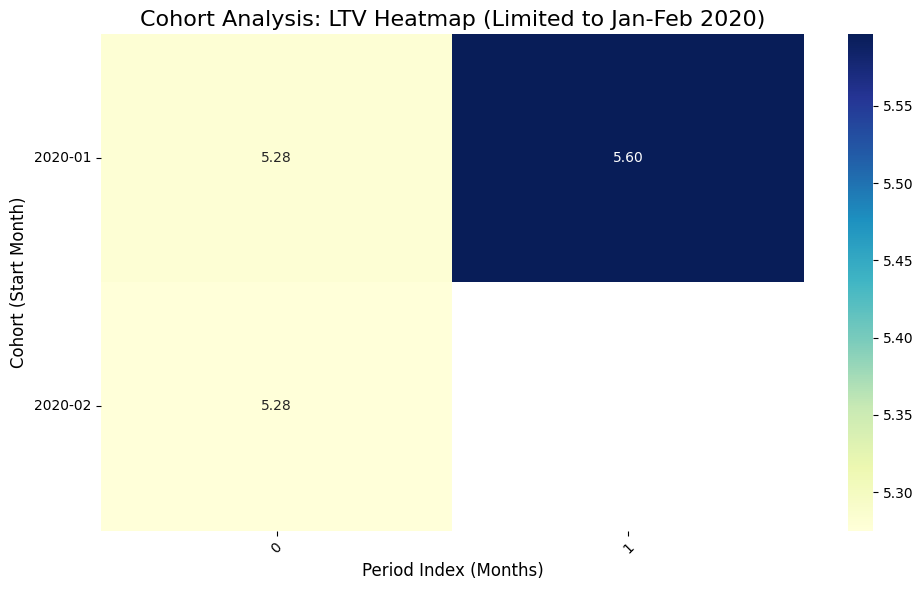

In [16]:
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
plt.title("Cohort Analysis: LTV Heatmap (Limited to Jan-Feb 2020)", fontsize=16)
plt.xlabel("Period Index (Months)", fontsize=12)
plt.ylabel("Cohort (Start Month)", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Задание 1.2

Спрогнозировать, каким будет LTV на полгода

In [17]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [18]:
cohort_data['cohort'] = cohort_data['cohort'].astype('datetime64[s]')

In [19]:
cohort_data

,cohort,period_index,total_users,total_revenue,LTV
0,2020-01-01,0,720,3802.38,5.281083
1,2020-01-01,1,107,598.80,5.596262
2,2020-02-01,0,1435,7569.83,5.275143


Рссчитаем прогноз на полгода методом линейной регрессии, потому что данных слишком мало для использования более сложных моделей

In [20]:
X = cohort_data[['period_index']].values  # Независимая переменная: period_index
y = cohort_data['LTV'].values  # Зависимая переменная: LTV

# Обучение линейной модели регрессии
linear_model = LinearRegression()
linear_model.fit(X, y)

# Генерация прогнозов для следующих 4 периодов за пределами текущих данных
additional_future_periods = np.arange(cohort_data['period_index'].max() + 1, cohort_data['period_index'].max() + 7).reshape(-1, 1)
additional_future_ltv_predictions = linear_model.predict(additional_future_periods)

# Подготовка данных для дополнительных будущих периодов
additional_future_ltv_data = pd.DataFrame({
    'future_period_index': additional_future_periods.flatten(),
    'predicted_LTV': additional_future_ltv_predictions
})
# Добавление столбца с соответствующими месяцами для прогнозируемых будущих периодов
latest_month = pd.to_datetime(cohort_data['cohort'].iloc[0]) + pd.DateOffset(months=cohort_data['period_index'].max() + 1)
additional_future_ltv_data['month'] = [
    (latest_month + pd.DateOffset(months=i)).strftime('%Y-%m') 
    for i in range(len(additional_future_ltv_data))
] 

In [21]:
additional_future_ltv_data

,future_period_index,predicted_LTV,month
0,2,5.914410,2020-03
1,3,6.232559,2020-04
2,4,6.550707,2020-05
3,5,6.868856,2020-06
4,6,7.187005,2020-07
5,7,7.505153,2020-08


## Задание 1.3

Построить график, который будет отображать кривую фактического LTV на
фоне кривой прогнозируемого LTV


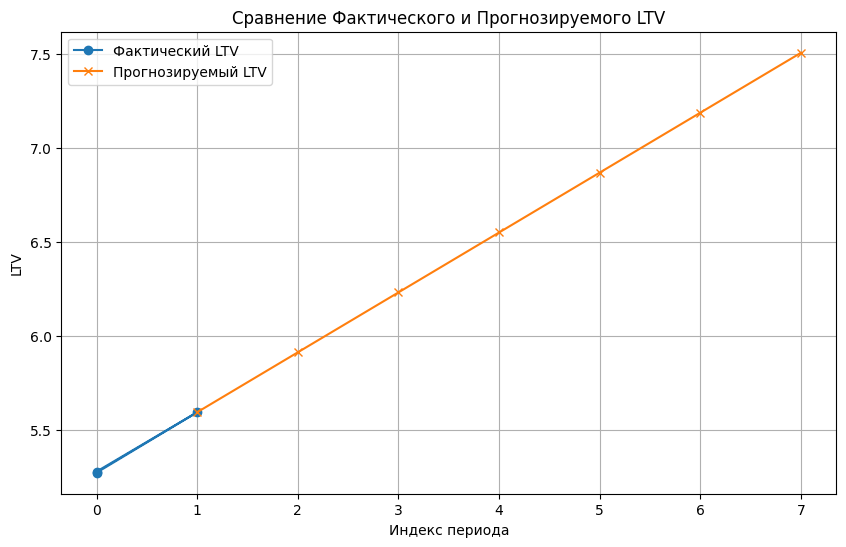

In [22]:
# Используем загруженные данные data1 и data2 вместо несуществующих объектов cohort_data и additional_future_ltv_data
cohort_data['period'] = cohort_data['period_index']
additional_future_ltv_data['period'] = additional_future_ltv_data['future_period_index']

# Готовим данные для графика
fact_LTV = cohort_data[['period', 'LTV']]
pred_LTV = additional_future_ltv_data[['period', 'predicted_LTV']]

# Соединение фактических и прогнозируемых данных для беспрерывной линии
last_fact_period = fact_LTV['period'].max()
first_pred_period = pred_LTV['period'].min()

# Если есть разрыв между периодами, добавляем соединяющую точку
if last_fact_period + 1 == first_pred_period:
    connection_value = fact_LTV[fact_LTV['period'] == last_fact_period]['LTV'].values[0]
    pred_LTV = pd.concat([pd.DataFrame({'period': [last_fact_period], 'predicted_LTV': [connection_value]}), pred_LTV], ignore_index=True)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(fact_LTV['period'], fact_LTV['LTV'], label='Фактический LTV', marker='o')
plt.plot(pred_LTV['period'], pred_LTV['predicted_LTV'], label='Прогнозируемый LTV', marker='x')
plt.title('Сравнение Фактического и Прогнозируемого LTV')
plt.xlabel('Индекс периода')
plt.ylabel('LTV')
plt.legend()
plt.grid()
plt.show()


In [23]:
cohort_data

,cohort,period_index,total_users,total_revenue,LTV,period
0,2020-01-01,0,720,3802.38,5.281083,0
1,2020-01-01,1,107,598.80,5.596262,1
2,2020-02-01,0,1435,7569.83,5.275143,0


In [24]:
additional_future_ltv_data

,future_period_index,predicted_LTV,month,period
0,2,5.914410,2020-03,2
1,3,6.232559,2020-04,3
2,4,6.550707,2020-05,4
3,5,6.868856,2020-06,5
4,6,7.187005,2020-07,6
5,7,7.505153,2020-08,7


## Задание 1.4

Рассчитать ROMI на 4 недели и на полгода, если стоимость привлечения
платящего пользователя 6 USD (ROMI нужно брать операционный, а не бухгалтерский,
цель: узнать как окупятся наши инвестиции).


In [25]:
# Фактические данные (первые 2 месяца)
ltv_fact_4_weeks = cohort_data[cohort_data['period'] <= 4]['LTV'].mean()

# Используем фактические данные (2 периода) и прогнозируемые данные (до 24 периода)
# Прогноз на 4 недели
ltv_4_weeks = additional_future_ltv_data[additional_future_ltv_data['future_period_index'] == 4]['predicted_LTV'].mean()

# Прогноз на 6 месяцев (экстраполяция уже выполнена)
ltv_6_months = ltv_24_weeks_pred

# ROMI расчет
romi_4_weeks = (ltv_4_weeks - cac) / cac * 100  # ROMI на 4 недели
romi_6_months = (ltv_6_months - cac) / cac * 100  # ROMI на полгода

ltv_4_weeks, romi_4_weeks, ltv_6_months, romi_6_months


NameError: name 'ltv_24_weeks_pred' is not defined

На основе фактических данных (за первые 2 месяца) и прогноза на 6 месяцев:

LTV через 4 недели = 6.55 USD.

ROMI через 4 недели = 9.18%.

LTV через 6 месяцев (24 недели) = 12.91 USD.

ROMI через 6 месяцев = 115.23%.

## Задание 2.1

Написать 2 SQL запроса для поиска значений среднего и медианы по сумме
продажи. Сумму транзакции округляем до целой части. Нельзя использовать
стандартные функции среднего и медианы в SQL. Можно использовать только агр.
функции SUM и COUN


In [658]:
import pandas as pd
from pandasql import sqldf
import numpy as np
import random 

Сгенерируем рандомные данные для создания нужных нам датафреймов

In [659]:
all_user_ids = np.arange(1, 1001)
all_product_ids = np.arange(1, 101)
all_amounts =  np.round(np.arange(0, 1000.01, 0.01), 2)
all_countries = ['USA', 'Canada', 'Germany', 'France', 'Japan', 'Australia', 'Brazil']
event_types = ['install', 'trial', 'purchase']
n = 10000
user_ids    = np.random.choice(all_user_ids, n)
product_ids = np.random.choice(all_product_ids, n)
amounts = np.random.choice(all_amounts, n)
countries_list = [random.choice(all_countries) for _ in range(n)]
event_types_list = [random.choice(event_types) for _ in range(n)]
start_date = pd.to_datetime('2020-01-01')
times = pd.date_range(start_date, periods=n, freq='1min')

In [660]:
orders = pd.DataFrame({'user_id': user_ids, 
                             'id': product_ids, 
                             'datetime': times, 
                             'sale_amount': amounts})

In [661]:
orders

,user_id,id,datetime,sale_amount
0,571,40,2020-01-01 00:00:00,78.17
1,802,51,2020-01-01 00:01:00,167.52
2,561,35,2020-01-01 00:02:00,225.06
3,513,70,2020-01-01 00:03:00,124.63
4,356,32,2020-01-01 00:04:00,817.18
...,...,...,...,...
9995,933,89,2020-01-07 22:35:00,474.06
9996,812,47,2020-01-07 22:36:00,278.21
9997,999,56,2020-01-07 22:37:00,3.68
9998,299,35,2020-01-07 22:38:00,254.08


Запрос поиска среднего

In [662]:
q = """SELECT 
    SUM(sale_amount) / COUNT(*) AS average_sale
FROM 
    orders;

"""

In [663]:
sqldf(q)

,average_sale
0,502.37948


Запрос поиска медианы

In [664]:
q = """WITH OrderedSales AS (
    SELECT 
        sale_amount,
        ROW_NUMBER() OVER (ORDER BY sale_amount) AS rn,
        COUNT(*) OVER () AS total_count
    FROM 
        orders
),
MedianCalc AS (
    SELECT 
        sale_amount AS median_value
    FROM 
        OrderedSales
    WHERE 
        rn = (total_count + 1) / 2 -- Для нечётного количества записей
    UNION ALL
    SELECT 
        AVG(sale_amount) AS median_value
    FROM 
        OrderedSales
    WHERE 
        rn IN (total_count / 2, total_count / 2 + 1) -- Для чётного количества записей
)
SELECT 
    ROUND(AVG(median_value)) AS median_sale
FROM 
    MedianCalc;
"""

In [665]:
sqldf(q)

,median_sale
0,505.0


## Задание 2.2

Написать SQL-запрос для поиска задублированных в результате ошибки
транзакций

In [666]:
purchases = pd.DataFrame({'user_id': user_ids, 
                             'transaction_id': product_ids, 
                             'datetime': times, 
                             'amount': amounts})

In [667]:
purchases

,user_id,transaction_id,datetime,amount
0,571,40,2020-01-01 00:00:00,78.17
1,802,51,2020-01-01 00:01:00,167.52
2,561,35,2020-01-01 00:02:00,225.06
3,513,70,2020-01-01 00:03:00,124.63
4,356,32,2020-01-01 00:04:00,817.18
...,...,...,...,...
9995,933,89,2020-01-07 22:35:00,474.06
9996,812,47,2020-01-07 22:36:00,278.21
9997,999,56,2020-01-07 22:37:00,3.68
9998,299,35,2020-01-07 22:38:00,254.08


In [668]:
q = """SELECT 
    transaction_id,
    datetime,
    amount,
    user_id,
    COUNT(*) AS duplicate_count
FROM 
    purchases
GROUP BY 
    datetime, 
    amount, 
    user_id
HAVING 
    COUNT(*) > 1;
"""

In [669]:
sqldf(q)

,transaction_id,datetime,amount,user_id,duplicate_count


## Задание 2.3

Написать SQL-запрос для построения воронки перехода из установки в
оформление пробного периода и в покупку платной версии приложения в разрезе
стран. На одного юзера возможна только одно оформление пробного периода и одна
покупка платной версии. Покупка возможна только после истечения срока пробного
периода. На выходе должна получится таблица с колонками “country”, “installs”, “trials”,
“purchases”, “conversion_rate_to_trial”, “conversion_rate_to_purchase”


In [670]:
events = pd.DataFrame({'user_id': user_ids, 
                             'transaction_id': product_ids, 
                             'datetime': times, 
                             'country': countries_list,
                             'event_type': event_types_list})

In [671]:
q = """WITH user_events AS (
    SELECT
        user_id,
        country,
        MAX(CASE WHEN event_type = 'install' THEN datetime END) AS install_date,
        MAX(CASE WHEN event_type = 'trial' THEN datetime END) AS trial_date,
        MAX(CASE WHEN event_type = 'purchase' THEN datetime END) AS purchase_date
    FROM events
    GROUP BY user_id, country
),
filtered_events AS (
    SELECT
        country,
        COUNT(DISTINCT user_id) FILTER (WHERE install_date IS NOT NULL) AS installs,
        COUNT(DISTINCT user_id) FILTER (WHERE trial_date IS NOT NULL AND trial_date > install_date) AS trials,
        COUNT(DISTINCT user_id) FILTER (WHERE purchase_date IS NOT NULL AND purchase_date > trial_date) AS purchases
    FROM user_events
    GROUP BY country
)
SELECT
    country,
    installs,
    trials,
    purchases,
    ROUND(CASE WHEN installs > 0 THEN (trials * 100.0 / installs) ELSE 0 END, 2) AS conversion_rate_to_trial,
    ROUND(CASE WHEN installs > 0 THEN (purchases * 100.0 / installs) ELSE 0 END, 2) AS conversion_rate_to_purchase
FROM filtered_events
ORDER BY country;
"""

In [672]:
sqldf(q)

,country,installs,trials,purchases,conversion_rate_to_trial,conversion_rate_to_purchase
0,Australia,393,68,77,17.30,19.59
1,Brazil,409,75,73,18.34,17.85
2,Canada,399,77,64,19.30,16.04
3,France,376,66,70,17.55,18.62
4,Germany,363,70,62,19.28,17.08
5,Japan,363,76,75,20.94,20.66
6,USA,377,68,76,18.04,20.16


## Задание 3

Продуктовый менеджер сформировал гипотезу, что новая версия экрана продаж будет
лучше перформить по сравнению со старой, в связи с тем, что на новом экране продаж
более понятно описаны преимущества платной версии приложения.
Продуктовый менеджер ожидает увеличение уровня конверсии из установки в покупку
платной версии приложения. Приложение тем временем уже очень активно
продвигается на рынке, каждый день привлекается в среднем по 30 000 новых
пользователей, текущий уровень конверсии из установки в покупку 5%.
Как бы вы предложили проверить данную гипотезу, какие инструменты и тесты бы
использовали в процессе проверки?

1. Формулировка гипотезы

Нулевая гипотеза (H₀): Уровень конверсии из установки в покупку в новой версии экрана (Группа B) равен уровню 
конверсии в текущей версии экрана (Группа A).

Альтернативная гипотеза (H₁): Уровень конверсии из установки в покупку в новой версии экрана (Группа B) выше, чем в текущей версии экрана (Группа A).

2. Определение метрики

Основная метрика: Конверсия из установки в покупку платной версии (в %).

Вспомогательные метрики:

Retention пользователей (удержание на определённый срок).

Средний чек (если есть варианты оплаты).

Отказ от использования приложения.

3. Дизайн эксперимента

Разделение пользователей на группы:



Группа A: 50% новых пользователей видят старую версию экрана продаж.

Группа B: 50% новых пользователей видят новую версию экрана.

Деление пользователей должно быть случайным, чтобы исключить систематические ошибки.

Объём выборки:



Текущая конверсия составляет 5%, то есть из 30 000 пользователей ежедневно совершают покупку 1 500 человек.

Для статистически значимого результата можно воспользоваться калькулятором размера выборки. Например, при ожидаемом приросте конверсии на 10% (с 5% до 5.5%) потребуется выборка около 10 000 пользователей на группу (для доверительного уровня 95% и мощности теста 80%).

Длительность эксперимента:



С учётом привлечения 30 000 пользователей в день, потребуется 1-2 дня для набора достаточного объёма данных.

4. Проведение эксперимента

Настроить A/B-тестирование через платформу аналитики (например, Firebase, Amplitude, Mixpanel или собственный инструмент).

Собрать данные о поведении пользователей и уровне конверсии для каждой группы.

5. Анализ результатов

Статистический тест:



Использовать z-тест или t-тест для сравнения пропорций в двух группах.

Проверить p-value. Если p-value < 0.05, отклоняем нулевую гипотезу и принимаем, что новая версия экрана лучше.

Дополнительный анализ:



Проверить, есть ли различия в поведении разных сегментов пользователей (например, по географии, устройству или другим характеристикам).

6. Принятие решения

Если новая версия экрана статистически значимо увеличивает конверсию, её стоит внедрить для всех пользователей.

Если результат незначим или конверсия снижается, оставить текущую версию экрана.

Инструменты для проверки

Сбор данных: Firebase, Amplitude, Mixpanel.

Анализ данных: Python, R, Excel или встроенные инструменты аналитики.

Визуализация: Tableau, Power BI.

